<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [ ]:
# default_exp e2e

In [ ]:
# export
import torch

from uberduck_ml_dev.text.symbols import NVIDIA_TACO2_SYMBOLS
from uberduck_ml_dev.text.util import text_to_sequence


def _pad_sequences(batch):
    input_lengths, ids_sorted_decreasing = torch.sort(
        torch.LongTensor([len(x) for x in batch]), dim=0, descending=True
    )
    max_input_len = input_lengths[0]

    text_padded = torch.LongTensor(len(batch), max_input_len)
    text_padded.zero_()
    for i in range(len(ids_sorted_decreasing)):
        text = batch[ids_sorted_decreasing[i]]
        text_padded[i, : text.size(0)] = text

    return text_padded, input_lengths, ids_sorted_decreasing


def prepare_input_sequence(
    texts, cpu_run=False, arpabet=False, symbol_set=NVIDIA_TACO2_SYMBOLS
):
    p_arpabet = float(arpabet)
    seqs = []
    for text in texts:
        seqs.append(
            torch.IntTensor(
                text_to_sequence(
                    text,
                    ["english_cleaners"],
                    p_arpabet=p_arpabet,
                    symbol_set=symbol_set,
                )[:]
            )
        )
    text_padded, input_lengths, sort_indices = _pad_sequences(seqs)
    if not cpu_run:
        text_padded = text_padded.cuda().long()
        input_lengths = input_lengths.cuda().long()
    else:
        text_padded = text_padded.long()
        input_lengths = input_lengths.long()

    return text_padded, input_lengths, sort_indices

In [ ]:
text, input_lengths, sort_indices = prepare_input_sequence(
    ["One", "Two three"], cpu_run=True
)
assert text.equal(
    torch.LongTensor(
        [[57, 60, 52, 11, 57, 45, 55, 42, 42], [52, 51, 42, 0, 0, 0, 0, 0, 0]]
    )
)
assert input_lengths.equal(torch.LongTensor([9, 3]))
assert sort_indices.equal(torch.LongTensor([1, 0]))
text, input_lengths, sort_indices = prepare_input_sequence(
    ["Two three", "one"], cpu_run=True, arpabet=1
)
assert text.equal(
    torch.LongTensor([[133, 141, 11, 134, 130, 113], [144, 74, 119, 0, 0, 0]])
)
assert input_lengths.equal(torch.LongTensor([6, 3]))
assert sort_indices.equal(torch.LongTensor([0, 1]))

In [ ]:
# export

from typing import List

from uberduck_ml_dev.models.tacotron2 import Tacotron2
from uberduck_ml_dev.vocoders.hifigan import HiFiGanGenerator


def tts(
    lines: List[str],
    model,
    device: str,
    vocoder,
    arpabet=False,
    symbol_set=NVIDIA_TACO2_SYMBOLS,
    max_wav_value=32768.0,
    speaker_ids=None,
):
    assert isinstance(
        model, Tacotron2
    ), "Only Tacotron2 text-to-mel models are supported"
    assert isinstance(vocoder, HiFiGanGenerator), "Only Hifi GAN vocoders are supported"
    cpu_run = device == "cpu"
    sequences, input_lengths, sort_indices = prepare_input_sequence(
        lines, cpu_run=cpu_run, arpabet=arpabet, symbol_set=symbol_set
    )
    if speaker_ids is None:
        speaker_ids = torch.zeros(len(lines), dtype=torch.long, device=device)
    input_ = sequences, input_lengths, speaker_ids
    _, inverse_indices = torch.sort(sort_indices)
    _, mel_outputs_postnet, gate_outputs, alignment, lengths = model.inference(input_)
    mels = mel_outputs_postnet[inverse_indices]
    lengths = lengths[inverse_indices]
    mel = mels[0, :, : lengths[0].item()]
    for idx in range(1, mels.size(0)):
        length = lengths[idx].item()
        mel = torch.cat((mel, mels[idx, :, :length]), dim=-1)
    tensor_cls = torch.FloatTensor if device == "cpu" else torch.cuda.FloatTensor
    mel = mel[None, :]
    y_g_hat = vocoder(tensor_cls(mel).to(device=device))
    audio = y_g_hat.reshape(1, -1)
    audio = audio * max_wav_value
    return audio

In [ ]:
# skip
from IPython import display as ipd

from uberduck_ml_dev.data_loader import MelSTFT
from uberduck_ml_dev.models.tacotron2 import DEFAULTS as TACOTRON2_DEFAULTS
from uberduck_ml_dev.text.symbols import NVIDIA_TACO2_SYMBOLS
from uberduck_ml_dev.vocoders.hifigan import HiFiGanGenerator
from uberduck_ml_dev.vendor.tfcompat.hparam import HParams

from IPython.display import display, Audio

print(type(TACOTRON2_DEFAULTS))
params = dict(**TACOTRON2_DEFAULTS.values())
print(params)
params.update(dict(has_speaker_embedding=True, n_speakers=7))
model = Tacotron2(HParams(**params))
# loaded = torch.load("../models/tacotron2-eminem-arpabet-400-2021-12-14.pt")
# loaded = torch.load("../models/tacotron2-trebek-arpa-740-01-02-21.pt", map_location="cpu")
loaded = torch.load("../models/tensorboard-ubstudio_v3_20epochcheckpoints_model_tacotron2_500.pt", map_location="cpu")
print(loaded.keys())
model.load_state_dict(loaded["model"])
hg = HiFiGanGenerator("../models/config_v1.json", "../models/g_02640000_studio")
model.eval()
hg.eval()
audio = tts(
    ["The quick brown fox jumped over the lazy dog."], model, "cpu", hg, arpabet=True,
)
ipd.display(ipd.Audio(audio, rate=22050))


<class 'uberduck_ml_dev.vendor.tfcompat.hparam.HParams'>
{'symbols_embedding_dim': 512, 'fp16_run': False, 'mask_padding': True, 'n_mel_channels': 80, 'encoder_kernel_size': 5, 'encoder_n_convolutions': 3, 'encoder_embedding_dim': 512, 'coarse_n_frames_per_step': None, 'decoder_rnn_dim': 1024, 'prenet_dim': 256, 'prenet_f0_n_layers': 1, 'prenet_f0_dim': 1, 'prenet_f0_kernel_size': 1, 'prenet_rms_dim': 0, 'prenet_fms_kernel_size': 1, 'max_decoder_steps': 1000, 'gate_threshold': 0.5, 'p_attention_dropout': 0.1, 'p_decoder_dropout': 0.1, 'p_teacher_forcing': 1.0, 'pos_weight': None, 'attention_rnn_dim': 1024, 'attention_dim': 128, 'attention_location_n_filters': 32, 'attention_location_kernel_size': 31, 'postnet_embedding_dim': 512, 'postnet_kernel_size': 5, 'postnet_n_convolutions': 5, 'n_speakers': 1, 'speaker_embedding_dim': 128, 'with_gst': True, 'ref_enc_filters': [32, 32, 64, 64, 128, 128], 'ref_enc_size': [3, 3], 'ref_enc_strides': [2, 2], 'ref_enc_pad': [1, 1], 'filter_length': 10

In [ ]:
audio = tts(
    ["It's like this and like that and like this."],
    model,
    "cpu",
    hg,
    arpabet=True,
    speaker_ids=torch.tensor([1]),
)
ipd.display(ipd.Audio(audio, rate=22050))


In [ ]:
# export

from typing import Optional

from uberduck_ml_dev.models.common import MelSTFT
from uberduck_ml_dev.utils.plot import plot_attention, plot_attention_phonemes


@torch.no_grad()
def rhythm_transfer(
    original_audio: torch.tensor,
    original_text: str,
    model,
    vocoder,
    device: str,
    symbol_set=NVIDIA_TACO2_SYMBOLS,
    arpabet=False,
    max_wav_value=32768.0,
    speaker_id=0,
    plot=False,
    attn=None
):
    assert len(original_audio.shape) == 1
    cpu_run = device == "cpu"
    p_arpabet = float(arpabet)
    sequence, input_lengths, _ = prepare_input_sequence(
        [original_text], arpabet=arpabet, cpu_run=cpu_run, symbol_set=symbol_set
    )
    speaker_ids = torch.tensor([speaker_id], dtype=torch.long, device=device)
    if attn is None:
        # TODO(zach): Support non-default STFT parameters.
        stft = MelSTFT()
        original_target_mel = stft.mel_spectrogram(original_audio[None])
        if not cpu_run:
            original_target_mel = original_target_mel.cuda()
        max_len = original_target_mel.size(2)
        inputs = (
            sequence,
            input_lengths,
            original_target_mel,
            max_len,
            torch.tensor([max_len], dtype=torch.long, device=device),
            speaker_ids,
        )
        attn = model.get_alignment(inputs)
    _, mel_postnet, _, _ = model.inference_noattention(
        (sequence, input_lengths, speaker_ids, attn.transpose(0, 1))
    )
    y_g_hat = vocoder(torch.tensor(mel_postnet, dtype=torch.float, device=device))
    audio = y_g_hat.reshape(1, -1)
    audio = audio * max_wav_value
    if plot:
        plot_attention(attn[0].transpose(0, 1))
        plot_attention_phonemes(sequence[0], attn[0].transpose(0, 1), NVIDIA_TACO2_SYMBOLS)
    return audio

/var/folders/9n/w8qrq4mx4cl_j036z8wg_9nh0000gp/T/ipykernel_60926/1844953815.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_g_hat = vocoder(torch.tensor(mel_postnet, dtype=torch.float, device=device))


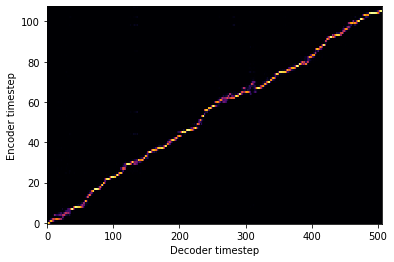

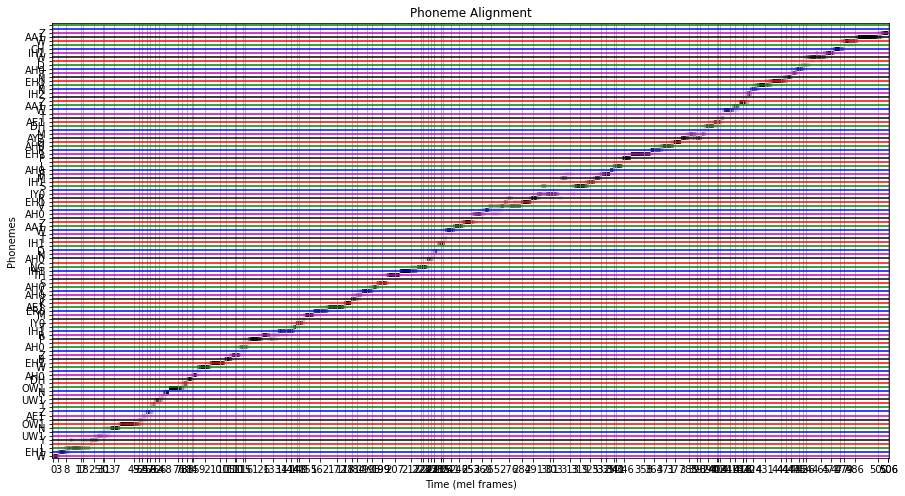

In [ ]:
# skip
%matplotlib inline
import IPython.display as ipd
import numpy as np
from scipy.io.wavfile import read

transcription = "Well you know as you know the web's a pretty miraculous thing and it was a very simple paradigm that was invented which was ."
# transcription = "It's like this and like that and like this."
# transcription = "now this looks like a job for me, so everybody, just follow me."
# sr, data = read("./test/fixtures/wavs/stevejobs-1.wav")

sr, data = read("./test/fixtures/wavs/stevejobs-trimmed.wav")
# sr, data = read("/Users/zwf/data/voice/zwf/wavs/1.wav")
assert sr == 22050
assert len(data.shape) == 1
assert isinstance(data, np.ndarray)
assert data.dtype == np.int16
data = torch.FloatTensor(data) / 32768.0
model.train()
audio = rhythm_transfer(data, transcription, model, hg, "cpu", arpabet=True, speaker_id=4, plot=True)
ipd.display(ipd.Audio(audio, rate=22050))

In [ ]:
from uberduck_ml_dev.utils.audio import trim_audio
# trim_audio("test/fixtures/zwf2.wav", "test/fixtures/zwf2-trimmed.wav")
trim_audio("./test/fixtures/wavs/stevejobs-1.wav", "test/fixtures/wavs/stevejobs-trimmed.wav")

In [ ]:
# ipd.Audio("test/fixtures/wavs/stevejobs-1.wav")
ipd.Audio("test/fixtures/zwf2-trimmed.wav", rate=22050)


In [ ]:
from uberduck_ml_dev.models.common import MelSTFT
stft = MelSTFT()
mel_target = stft.mel_spectrogram(data[None])
max_len = mel_target.size(2)
sequence, input_lengths, _ = prepare_input_sequence(
    [transcription], arpabet=True, cpu_run=True, symbol_set=NVIDIA_TACO2_SYMBOLS
)
inputs = (
    sequence,
    input_lengths,
    mel_target,
    max_len,
    torch.tensor([max_len], dtype=torch.long),
    torch.tensor([4]),
)
attn = model.get_alignment(inputs)

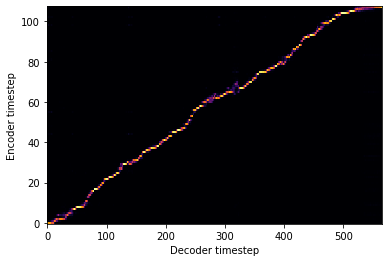

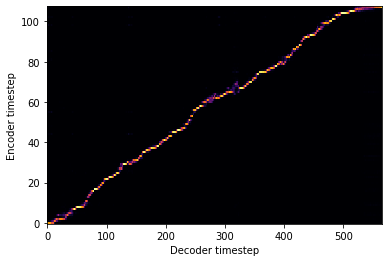

In [ ]:
plot_attention(attn[0].transpose(0, 1))

/var/folders/9n/w8qrq4mx4cl_j036z8wg_9nh0000gp/T/ipykernel_60926/1844953815.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_g_hat = vocoder(torch.tensor(mel_postnet, dtype=torch.float, device=device))


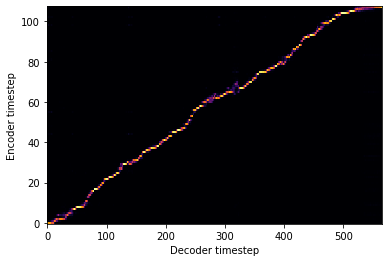

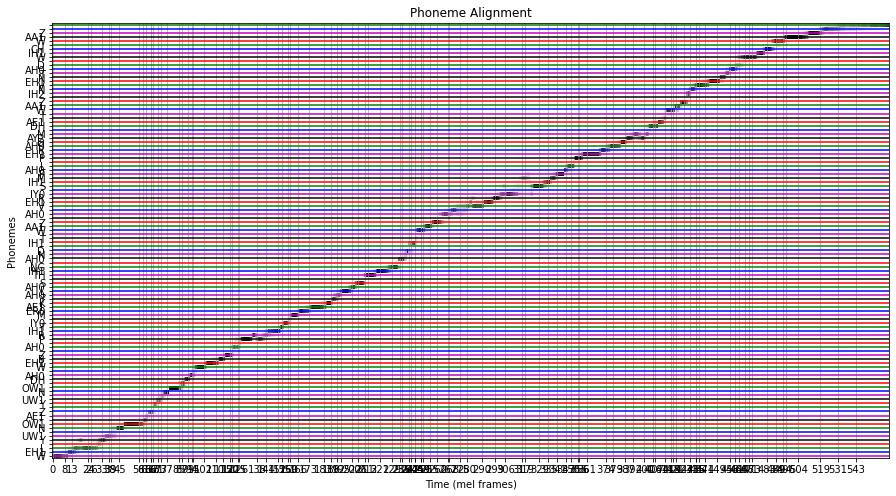

In [ ]:
audio = rhythm_transfer(
    data,
    transcription,
    model,
    hg,
    "cpu",
    arpabet=True,
    speaker_id=0,
    plot=True,
    attn=attn,
)

In [ ]:
ipd.Audio(audio, rate=22050)

In [ ]:
attn.shape
_attn = attn[0]
improved_attn = torch.empty_like(attn)
for idx, decoder_frame in enumerate(_attn):
    hard_frame = torch.zeros_like(decoder_frame)
    hard_frame[decoder_frame.argmax()] = 1.0
    improved_attn[0, idx, :] = hard_frame
# for idx, decoder_frame in enumerate(_attn):
#     hard_frame = torch.zeros_like(decoder_frame)
#     if idx == 0:
#         improved_attn[0, idx, :] = hard_frame
#         continue

/var/folders/9n/w8qrq4mx4cl_j036z8wg_9nh0000gp/T/ipykernel_60926/1844953815.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_g_hat = vocoder(torch.tensor(mel_postnet, dtype=torch.float, device=device))


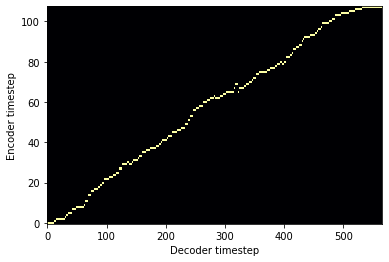

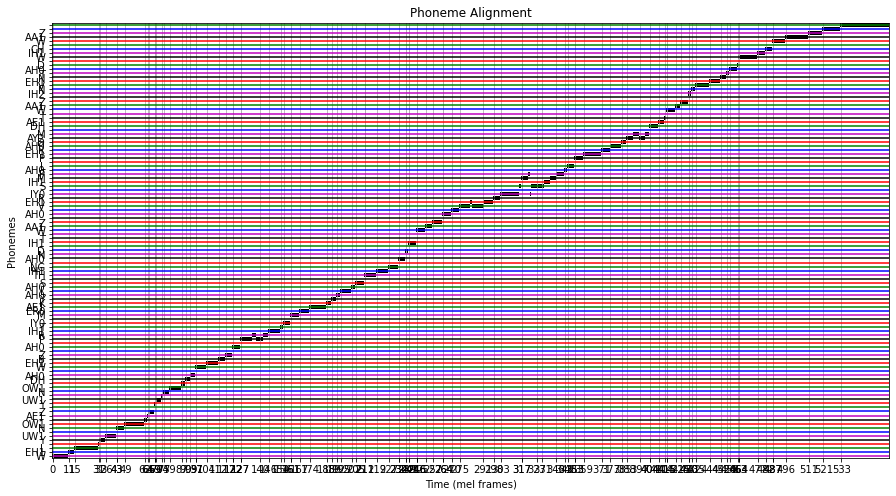

In [ ]:
audio = rhythm_transfer(
    data,
    transcription,
    model,
    hg,
    "cpu",
    arpabet=True,
    speaker_id=0,
    plot=True,
    attn=improved_attn,
)
ipd.display(ipd.Audio(audio, rate=22050))

In [ ]:
sequence

tensor([[144,  94, 117,  11, 145, 141,  11, 119, 123,  11,  70, 146,  11, 145,
         141,  11, 119, 123,  11,  91,  73,  11, 144,  94,  88, 146,  11,  73,
          11, 129, 130, 109, 133, 112,  11, 118,  97,  70, 116, 145,  73, 117,
          73, 131,  11, 134, 109, 120,  11,  73, 119,  90,  11, 109, 133,  11,
         144,  66, 146,  11,  73,  11, 143,  94, 130, 112,  11, 131, 109, 118,
         129,  73, 117,  11, 129,  94, 130,  73,  90,  87, 118,  11,  91,  70,
         133,  11, 144,  66, 146,  11, 110, 119, 143,  94, 119, 133,  73,  90,
          11, 144, 109,  89,  11, 144,  66, 146,  11,   7]])

In [ ]:
sequence.shape

torch.Size([1, 108])

In [ ]:
from uberduck_ml_dev.text.util import convert_to_arpabet
print(convert_to_arpabet(transcription))

{ W EH1 L } { Y UW1 } { N OW1 } { AE1 Z } { Y UW1 } { N OW1 } { DH AH0 } { W EH1 B Z } { AH0 } { P R IH1 T IY0 } { M ER0 AE1 K Y AH0 L AH0 S } { TH IH1 NG } { AH0 N D } { IH1 T } { W AA1 Z } { AH0 } { V EH1 R IY0 } { S IH1 M P AH0 L } { P EH1 R AH0 D AY2 M } { DH AE1 T } { W AA1 Z } { IH2 N V EH1 N T AH0 D } { W IH1 CH } { W AA1 Z } .


In [ ]:
attn.shape

torch.Size([1, 566, 111])

In [ ]:
durations_with_blanks = [18,  1,  0,  1,  0,  1, 23,  3,  2,  1,  0,  1,  0,  1,  3,  1,  1,
        1,  0,  1,  1,  1,  0,  1,  6,  3,  0,  1,  0,  1,  8,  2,  0,  1,
        0,  1,  7,  3,  1,  1,  0,  1,  7,  3,  0,  1,  0,  1,  0,  1,  0,
        1, 11,  3,  1,  1, 20,  3,  0,  1,  0,  1,  0,  1,  0,  2,  5,  1,
        5,  2,  0,  2,  0,  1,  8,  1,  0,  1, 13,  1,  0,  1,  0,  1,  7,
        1,  0,  1, 15,  3,  0,  1,  0,  1,  0,  1,  6,  3,  1,  1,  0,  1,
        0,  1,  1,  3,  1,  1,  0,  1,  4,  3,  0,  1,  0,  1,  0,  1, 14,
        3, 22,  1, 12,  3,  0,  1,  0,  1,  0,  1,  6,  2, 11,  4,  0,  1,
        0,  1,  0,  1,  0,  1,  8,  1,  0,  1, 15,  4,  0,  1,  0,  1,  0,
        1,  8,  1, 10,  1,  0,  1,  0,  1, 13,  3,  0,  1,  0,  1,  0,  1,
        4,  3,  0,  1,  0,  1,  0,  1,  5,  2,  1,  1,  0,  1, 14,  1,  0,
        1,  0,  1,  0,  1, 11,  1,  0,  1,  8,  3,  1,  1,  0,  1,  0,  1,
       16,  3,  0,  1,  0,  1,  0,  1, 60,  1,  0,  1,  0]

In [ ]:
attn.shape
improved_attn = torch.zeros_like(attn)
total_frames = 0
cum_duration = 0
for token_idx, token_duration in enumerate(durations_with_blanks):
    start_frame = total_frames
    for frame in range(token_duration):
        current_frame = torch.zeros(attn.size(2))
        is_blank = token_idx % 2 == 0
        if token_idx == 0:
            current_frame[token_idx] = 1.0
        elif is_blank:
            current_frame[token_idx // 2 - 1] = 0.5
            current_frame[token_idx // 2] = 0.5
        else:
            current_frame[token_idx // 2] = 1.0
        improved_attn[0][total_frames][:] = current_frame
        total_frames += 1


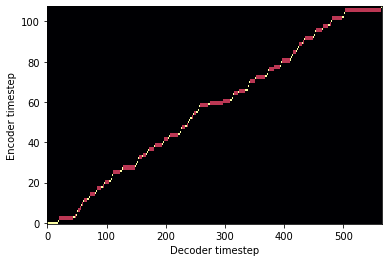

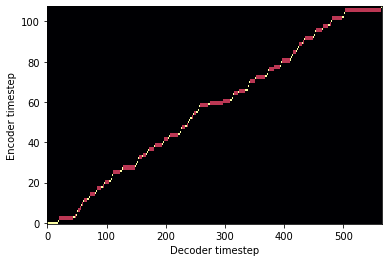

In [ ]:
plot_attention(improved_attn[0].transpose(0, 1))

/var/folders/9n/w8qrq4mx4cl_j036z8wg_9nh0000gp/T/ipykernel_60926/1844953815.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_g_hat = vocoder(torch.tensor(mel_postnet, dtype=torch.float, device=device))


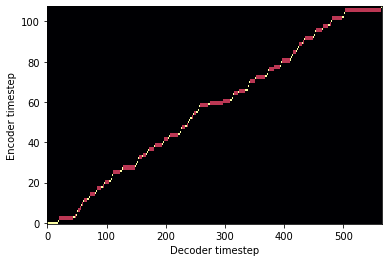

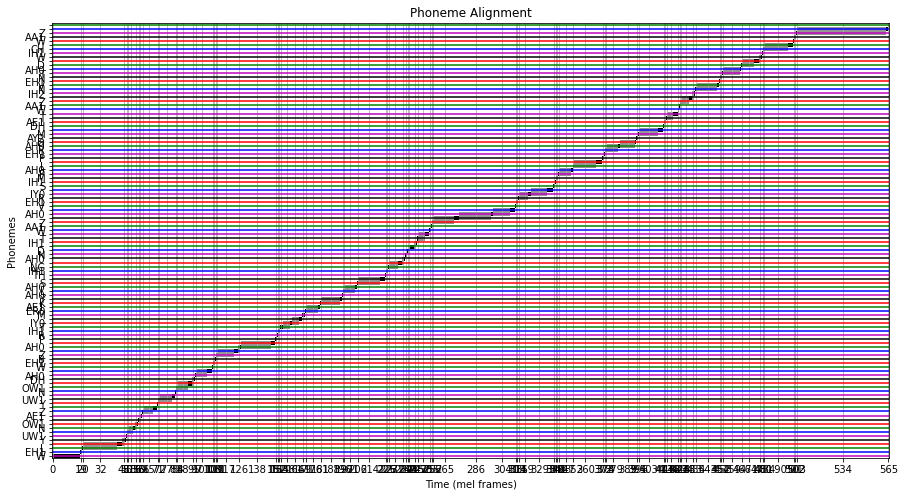

In [ ]:
audio = rhythm_transfer(
    data,
    transcription,
    model,
    hg,
    "cpu",
    arpabet=True,
    speaker_id=0,
    plot=True,
    attn=improved_attn,
)
ipd.display(ipd.Audio(audio, rate=22050))

In [ ]:
improved_attn.shape

torch.Size([1, 566, 108])

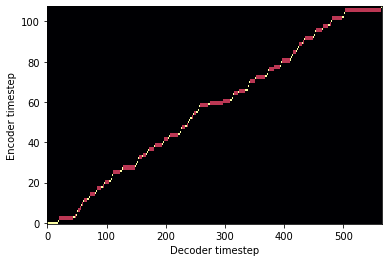

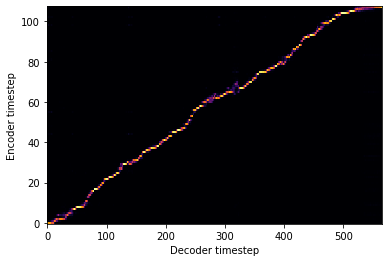

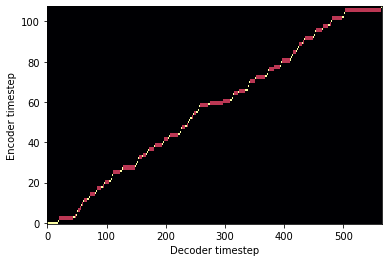

In [ ]:
%matplotlib inline
plot_attention(attn[0].transpose(0, 1))
plot_attention(improved_attn[0].transpose(0, 1))